In [42]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import yfinance as yf

# Reading and storing the Data

In [25]:
xls = pd.ExcelFile('data/data_for_testing.xlsx')
all_data = {}
# This is too much data to load into memory at once
# for sheet in xls.sheet_names:
#     all_data[sheet] = pd.read_excel(xls, sheet_name=sheet)
for sheet in ["XOM", "SHW", "UPS", "DUK", "UNH", "JPM", "AMZN", "AAPL", "META", "AMT"]:
    data = pd.read_excel(xls, sheet_name=sheet).set_index('Date')
    # Resample to monthly data as a simple way to reduce the number of data points
    # Daily data is too much and take too long to train
    monthly_data = data.resample('M').last().reset_index()
    all_data[sheet] = monthly_data

In [89]:
all_data['XOM'].head()

,Date,Open,...,Sector,Ticker
0,1962-01-31,0.0,...,Energy,XOM
1,1962-02-28,0.0,...,Energy,XOM
2,1962-03-31,0.0,...,Energy,XOM
3,1962-04-30,0.0,...,Energy,XOM
4,1962-05-31,0.0,...,Energy,XOM


In [26]:
all_data["AAPL"].columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Sector',
       'Ticker'],
      dtype='object')

In [5]:
def create_sequences(data, time_steps=60):
    """
    Create sequences from the data.

    Parameters:
    - data: Original time series data.
    - time_steps: Number of time steps in each sequence.

    Returns:
    - X: Sequences
    - y: Targets (the subsequent values)
    """
    
    X, y = [], []

    for i in range(len(data) - time_steps):
        # Extract the sequence and the subsequent value
        seq = data[i:(i + time_steps)]
        target = data[i + time_steps]
        
        X.append(seq)
        y.append(target)

    return np.array(X), np.array(y)


In [29]:
def create_model(time_steps, features, lose="mse"):
    model = Sequential()
    # 10 is not a good number of neurons, but it's a start for testing
    # 50 is a good number of neurons, but it takes a long time to train
    model.add(LSTM(10, activation='relu', input_shape=(time_steps, features)))
    model.add(Dense(features))
    model.compile(optimizer='adam', loss=lose)
    return model

In [30]:
final_importance_values = {}
final_predictions = {}
scalers = {}
# 30 is not a good number of batches, but it's a start for testing
# 60 is a good number of batches, but it takes a long time to train
time_steps = 30
features = 6
# Loop through each stock data
for ticker, data in all_data.items():
    
    # Drop non-numeric columns
    data = data.drop(columns=['Sector', 'Ticker', 'Date'])  # Assuming 'Date' is the index
    
    # Normalize the data
    scaler = MinMaxScaler()
    data_normalized = scaler.fit_transform(data)
    scalers[ticker] = scaler
    
    # Create sequences
    X, y = create_sequences(data_normalized, time_steps=time_steps)
    
    # Split data
    train_size = int(0.7 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Build and train the LSTM model on each stock data
    model = create_model(time_steps=time_steps, features=features)   
    model.fit(X_train, y_train, epochs=3, batch_size=4, validation_split=0.2, verbose=0)
    '''
    Batch Size: Refers to the number of training examples utilized in one iteration. When you set batch_size=32, it means the model takes 32 sequences at a time and updates weights once after computing the loss of the entire batch.
    Input Shape (60, 6): Refers to the shape of a single input sequence.
    60 indicates the number of time steps in each sequence. In your case, each sequence contains data from 60 days.
    6 refers to the number of features ('Open', 'High', 'Low', 'Close', 'Adj Close', and 'Volume').
    So, when you train your LSTM, it takes in 32 sequences (if we consider batch_size=32) at a time, and each of those sequences contains 60 time steps with 6 features for each time step.

    In simpler terms:

    Input Shape: Shape of a single sequence that you feed into the model.
    Batch Size: Number of sequences you feed into the model at one go.
    These two are different parameters and have different roles in the training process. The batch size is related to how you update the weights during training, whereas the input shape is related to the structure and size of your input data.
    '''
    
    # Predict the next day value
    last_days = data_normalized[-time_steps:].reshape(1, time_steps, features)
    prediction_next_day = model.predict(last_days)
    final_predictions[ticker] = prediction_next_day.flatten()
    print(f"Predicted value for {ticker}: {prediction_next_day.flatten()}")

    
    # Extracting importance
    dense_weights = model.layers[-1].get_weights()[0]

    # Think about to use sum or mean and to use abs() or not
    feature_weights = dense_weights.sum(axis=0)
    weighted_importance = prediction_next_day.flatten() * feature_weights
    final_importance_value = np.sum(weighted_importance)  # Final importance as a single value
    print(f"Importance value for {ticker}: {final_importance_value}")
    
    # Store the importance value in the dictionary
    final_importance_values[ticker] = final_importance_value

print(final_importance_values)

2023-09-18 15:23:07.382972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-18 15:25:27.131764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 258ms/step


2023-09-18 15:30:15.454072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Predicted value for XOM: [-0.10934462  0.7936239   1.3321731   0.9406815  -0.10562718  0.01945164]
Importance value for XOM: 1.2467446327209473


2023-09-18 15:30:16.129468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-18 15:31:05.168861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 245ms/step
Predicted value for SHW: [0.7142233  1.1717377  0.4699628  0.7068581  0.7867955  0.01304184]
Importance value for SHW: 1.6542071104049683


2023-09-18 15:32:49.212168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-18 15:32:49.951403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-18 15:33:39.718783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 236ms/step
Predicted value for UPS: [0.5924905  0.8160627  0.582283   0.7064813  0.28118685 1.0167204 ]
Importance value for UPS: 2.4096693992614746


2023-09-18 15:35:21.064819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-18 15:35:21.665791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-18 15:36:10.677535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 241ms/step
Predicted value for DUK: [-3.071432   -3.7180383   0.6870953  -1.0883465   2.209685   -0.57157284]
Importance value for DUK: 4.274110317230225


2023-09-18 15:37:55.558307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-18 15:37:56.178143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-18 15:38:39.944114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 248ms/step
Predicted value for UNH: [4.535069   0.70253235 2.2081325  0.99962765 3.8794105  1.969738  ]
Importance value for UNH: 0.09965753555297852


2023-09-18 15:40:12.812346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-18 15:40:13.432468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-18 15:41:03.489262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-18 15:48:59.897284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 277ms/step
Predicted value for JPM: [1.2420801  2.004749   2.0116382  1.6839278  0.9837139  0.30451494]
Importance value for JPM: 4.18166971206665


2023-09-18 15:49:00.673337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-18 15:49:34.013679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s

2023-09-18 15:50:43.183198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 295ms/step
Predicted value for AMZN: [ 0.00329451  0.60268044  0.7308001  -0.01342959  0.25307304  0.95916796]
Importance value for AMZN: 1.646519422531128


2023-09-18 15:50:44.003904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-18 15:52:28.052300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-18 15:55:57.943352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 287ms/step
Predicted value for AAPL: [ 0.05479512 -0.29919365 -0.17938155  0.28594506  0.0717153   0.44027317]
Importance value for AAPL: -0.36211806535720825


2023-09-18 15:55:58.741759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-18 15:56:24.613576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 261ms/step


2023-09-18 15:57:13.253976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Predicted value for META: [0.01556144 0.2573932  0.15435773 0.25018632 0.7994114  0.21757899]
Importance value for META: 1.5426522493362427


2023-09-18 15:57:14.044595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-18 15:58:10.292928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 275ms/step


2023-09-18 16:00:02.914103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Predicted value for AMT: [0.46217626 0.79730564 0.17581792 0.67005026 0.51907367 1.1350367 ]
Importance value for AMT: 3.4579238891601562
{'XOM': 1.2467446, 'SHW': 1.6542071, 'UPS': 2.4096694, 'DUK': 4.2741103, 'UNH': 0.099657536, 'JPM': 4.1816697, 'AMZN': 1.6465194, 'AAPL': -0.36211807, 'META': 1.5426522, 'AMT': 3.457924}


In [33]:
final_importance_values

{'XOM': 1.2467446,
 'SHW': 1.6542071,
 'UPS': 2.4096694,
 'DUK': 4.2741103,
 'UNH': 0.099657536,
 'JPM': 4.1816697,
 'AMZN': 1.6465194,
 'AAPL': -0.36211807,
 'META': 1.5426522,
 'AMT': 3.457924}

In [36]:
importance_values = np.array(list(final_importance_values.values()))

# 1. Scale the values to [-1, 1]
scaled_importance = 2 * (importance_values - np.min(importance_values)) / (np.max(importance_values) - np.min(importance_values)) - 1

# 2. Ensure the sum is zero
final_normalized_importance = scaled_importance - np.mean(scaled_importance)

# Convert back to dictionary
normalized_ticker_to_importance = dict(zip(final_importance_values.keys(), final_normalized_importance))

print(normalized_ticker_to_importance)

{'XOM': -0.33145866, 'SHW': -0.15568534, 'UPS': 0.17020974, 'DUK': 0.97450197, 'UNH': -0.8262949, 'JPM': 0.93462443, 'AMZN': -0.1590018, 'AAPL': -1.025498, 'META': -0.20380846, 'AMT': 0.62241113}


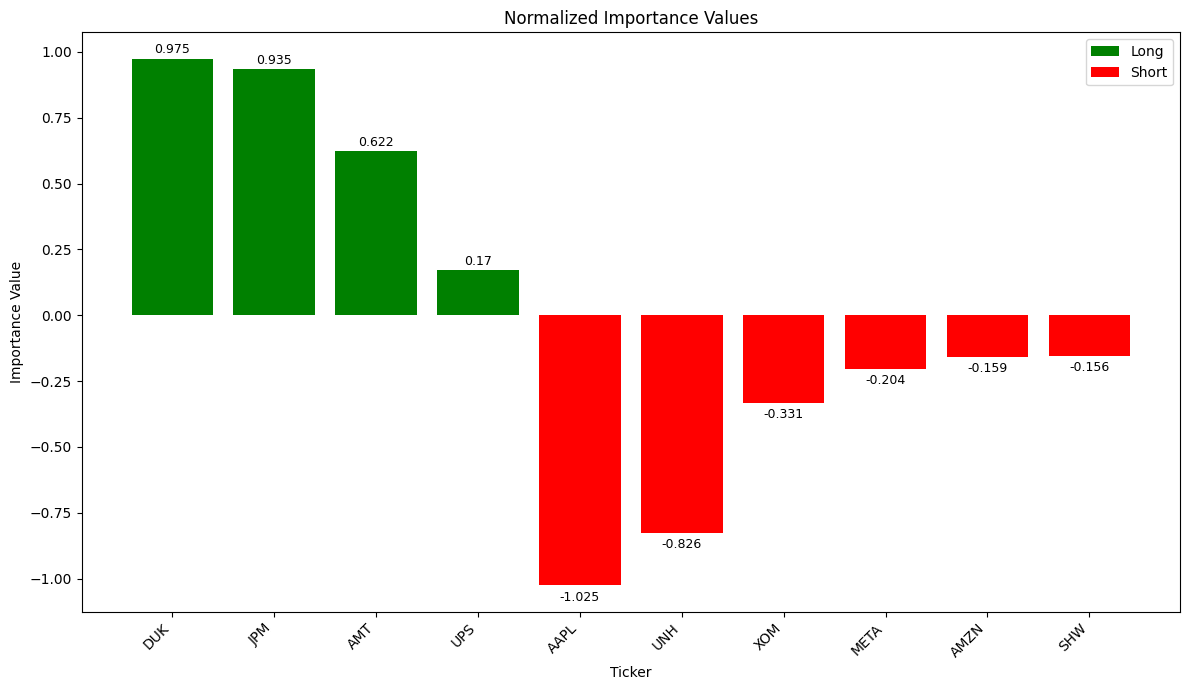

In [40]:
import matplotlib.pyplot as plt

# Split the tickers and importance values based on positive and negative values
long_positions = {k: v for k, v in normalized_ticker_to_importance.items() if v > 0}
short_positions = {k: v for k, v in normalized_ticker_to_importance.items() if v <= 0}

# Sort the positions for better visualization
sorted_long = dict(sorted(long_positions.items(), key=lambda item: item[1], reverse=True))
sorted_short = dict(sorted(short_positions.items(), key=lambda item: item[1]))

# Create bar charts
fig, ax = plt.subplots(figsize=(12, 7))

# Positive cluster
bars_long = ax.bar(sorted_long.keys(), sorted_long.values(), color='g', label='Long')

# Negative cluster
bars_short = ax.bar(sorted_short.keys(), sorted_short.values(), color='r', label='Short')

# Rotate x-tick labels for better readability
plt.xticks(rotation=45, ha='right')

# Annotate the bars
for bar in bars_long:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom', fontsize=9)

for bar in bars_short:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval - 0.02, round(yval, 3), ha='center', va='top', fontsize=9)

ax.set_title('Normalized Importance Values')
ax.set_ylabel('Importance Value')
ax.set_xlabel('Ticker')
ax.legend()

plt.tight_layout()
plt.show()


In [44]:
spy_data = yf.download('SPY')
spy_monthly = spy_data.resample('M').last()
spy_monthly

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-31,43.968750,43.968750,43.750000,43.937500,24.941393,1003200
1993-02-28,44.437500,44.437500,44.187500,44.406250,25.207474,66200
1993-03-31,45.343750,45.468750,45.187500,45.187500,25.772108,111600
1993-04-30,44.125000,44.281250,44.031250,44.031250,25.112656,88500
1993-05-31,45.406250,45.406250,45.000000,45.218750,25.789921,79100
...,...,...,...,...,...,...
2023-05-31,418.279999,419.220001,416.220001,417.850006,414.840332,110811800
2023-06-30,441.440002,444.299988,441.109985,443.279999,441.721893,104921500
2023-07-31,457.410004,458.160004,456.049988,457.790009,456.180908,62040400


In [59]:
all_data

{'XOM':           Date        Open        High         Low       Close   Adj Close  \
 0   1962-01-31    0.000000    1.656250    1.636719    1.656250    0.101445   
 1   1962-02-28    0.000000    1.757813    1.726563    1.730469    0.107163   
 2   1962-03-31    0.000000    1.710938    1.703125    1.707031    0.105711   
 3   1962-04-30    0.000000    1.710938    1.671875    1.671875    0.103534   
 4   1962-05-31    0.000000    1.632813    1.609375    1.625000    0.101744   
 ..         ...         ...         ...         ...         ...         ...   
 736 2023-05-31  102.290001  103.040001  101.739998  102.180000  101.349197   
 737 2023-06-30  107.320000  107.879997  106.809998  107.250000  106.377975   
 738 2023-07-31  105.190002  107.860001  105.190002  107.239998  106.368050   
 739 2023-08-31  111.120003  111.419998  110.620003  111.190002  111.190002   
 740 2023-09-30  117.550003  118.660004  117.320000  118.345001  118.345001   
 
        Volume  Sector Ticker  
 0     1718

In [104]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 5)

            Cumulative Portfolio  Cumulative SPY
Date                                            
1993-01-31             -0.998865        0.000000
1993-02-28             -0.998418        0.010668
1993-03-31             -0.998568        0.033307
1993-04-30             -0.998680        0.006867
1993-05-31             -0.998925        0.034021
...                          ...             ...
2019-08-31             -1.000000        9.950418
2019-09-30             -1.000000       10.163490
2019-10-31             -1.000000       10.410252
2019-11-30             -1.000000       10.823284
2019-12-31             -1.000000       11.166817

[324 rows x 2 columns]


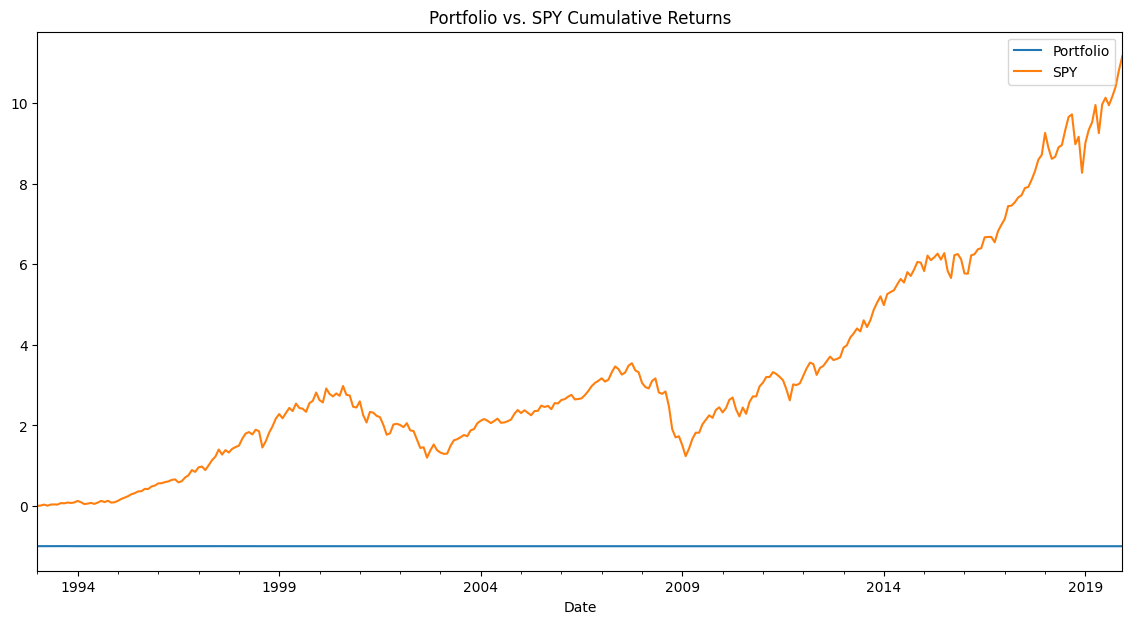

In [102]:
# Construct the Portfolio and Backtest
portfolio_returns = pd.DataFrame()
for ticker, importance in normalized_ticker_to_importance.items():
    data = all_data[ticker].set_index('Date')
    data['Returns'] = data['Adj Close'].pct_change().fillna(0)
    portfolio_returns[ticker] = data['Returns'] * importance
portfolio_returns['Portfolio'] = portfolio_returns.sum(axis=1)
spy_monthly['SPY Returns'] = spy_monthly['Adj Close'].pct_change().fillna(0)
# Cumulative Returns
portfolio_returns['Cumulative Portfolio'] = (portfolio_returns['Portfolio'] + 1).cumprod() - 1
spy_monthly['Cumulative SPY'] = (spy_monthly['SPY Returns'] + 1).cumprod() - 1
combined = pd.concat([portfolio_returns['Cumulative Portfolio'], spy_monthly['Cumulative SPY']], axis=1).dropna()
print(combined)
# Plot
plt.figure(figsize=(14,7))
combined['Cumulative Portfolio'].plot(label="Portfolio")
combined['Cumulative SPY'].plot(label="SPY")
plt.legend()
plt.title("Portfolio vs. SPY Cumulative Returns")
plt.show()


In [105]:
combined

,Cumulative Portfolio,Cumulative SPY
Date,,
1993-01-31,-0.998865,0.000000
1993-02-28,-0.998418,0.010668
1993-03-31,-0.998568,0.033307
1993-04-30,-0.998680,0.006867
1993-05-31,-0.998925,0.034021
...,...,...
2019-08-31,-1.000000,9.950418
2019-09-30,-1.000000,10.163490
2019-10-31,-1.000000,10.410252


<Axes: xlabel='Date'>

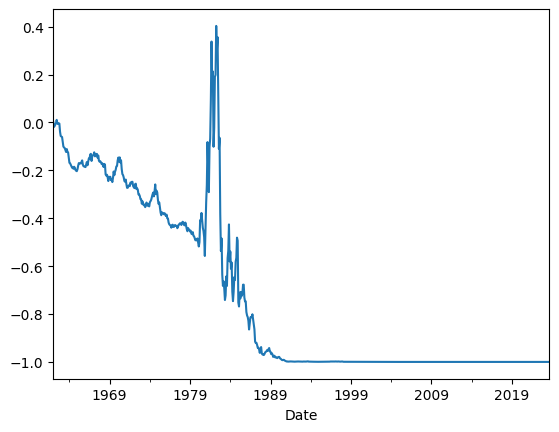

In [106]:
portfolio_returns["Cumulative Portfolio"].plot()